In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#         break
    break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,DepthwiseConv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2024-06-27 06:03:01.318211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 06:03:01.318331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 06:03:01.438239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
mapped_dict_2 = {'CI': 0, 'AD': 1, 'CN': 2}


In [4]:
fold_number = 9
data = []
folder = f"/kaggle/input/merged-ad-and-adni/Alzheimer Merged Dataset/fold_{fold_number}"
train_dir = os.path.join(folder, 'train')
test_dir = os.path.join(folder, 'test')

X_train = []
y_train = []
X_test = []
y_test = []

for filename in os.listdir(train_dir):
    class_path = os.path.join(train_dir,filename)
    class_label = filename[-1]
    for images in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path,images), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if img is not None:
            X_train.append(img)
            y_train.append(class_label)

for filename in os.listdir(test_dir):
    class_path = os.path.join(test_dir,filename)
    class_label = filename[-1]
    for images in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path,images), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if img is not None:
            X_test.append(img)
            y_test.append(class_label)

In [5]:
len(X_train), len(y_train), len(X_test), len(y_test)

(10399, 10399, 1155, 1155)

In [6]:
X_t = np.array(X_train)
y_t = np.array(y_train)

In [7]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
for train_index, val_index in stratified_split.split(X_t,y_t):
  X_train, X_val = X_t[train_index], X_t[val_index]
  y_train, y_val = y_t[train_index], y_t[val_index]

In [8]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [9]:
from collections import Counter

train_class_counts = Counter(y_train)
val_class_counts = Counter(y_val)
test_class_counts = Counter(y_test)

print("Training Set Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation Set Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest Set Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")


Training Set Class Counts:
Class 1: 855 samples
Class 0: 4123 samples
Class 2: 3341 samples

Validation Set Class Counts:
Class 2: 835 samples
Class 0: 1031 samples
Class 1: 214 samples

Test Set Class Counts:
Class 1: 119 samples
Class 2: 464 samples
Class 0: 572 samples


In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [11]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch,lr):
    if epoch < 8:
        return lr
    else:
        return 0.95*lr

In [12]:
lr_scheduler = LearningRateScheduler(lr_schedule)
optimizer = Adam(learning_rate=0.00095)

In [13]:
from keras import layers
from keras import models
import tensorflow as tf

In [14]:
class NegativeLayer(layers.Layer):
  def __init__(self):
    super(NegativeLayer,self).__init__()

  def build(self,input_shape):
    super(NegativeLayer,self).build(input_shape)

  @staticmethod
  def call(inp, **kwargs):
    return tf.negative(inp)*0.8

  def compute_output_shape(self,input_shape):
    return input_shape
# return super(NegativeLayer, self).compute_output_shape(input_shape)

In [15]:
model = Sequential()
inputs = layers.Input(shape=(224, 224, 3), name="Input")

x = layers.BatchNormalization()(inputs)
x = layers.Conv2D(16, (5, 5),padding="same", input_shape=(224, 224, 3), activation='relu')(x)
p1 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(p1)

x = layers.Conv2D(32, (3, 3), padding="same", activation='relu')(x)
p2 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(p2)

x = layers.Conv2D(64, (3, 3), padding="same", activation='relu')(x)
p3 =  layers.MaxPooling2D(pool_size=(2, 2))(x)
c1 = layers.BatchNormalization()(p3)

n1 = NegativeLayer()(c1)
x = layers.Conv2D(32, (3, 3),padding="same", activation='relu')(n1)
x = layers.BatchNormalization()(x)
p7 = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, (3, 3),padding="same", activation='relu')(p7)
x = layers.BatchNormalization()(x)
p8 = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(96, (3, 3), padding="same", activation='relu')(c1)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(p4)

x = layers.Conv2D(128, (3, 3), padding="same", activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.DepthwiseConv2D((3, 3),padding="same",activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.DepthwiseConv2D((3, 3),padding="same",activation='relu')(x)
c2 = layers.BatchNormalization()(x)


merge_layer = layers.Concatenate()([c2,p8])
x = layers.GlobalAveragePooling2D(name="GAP")(merge_layer)

outputs = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


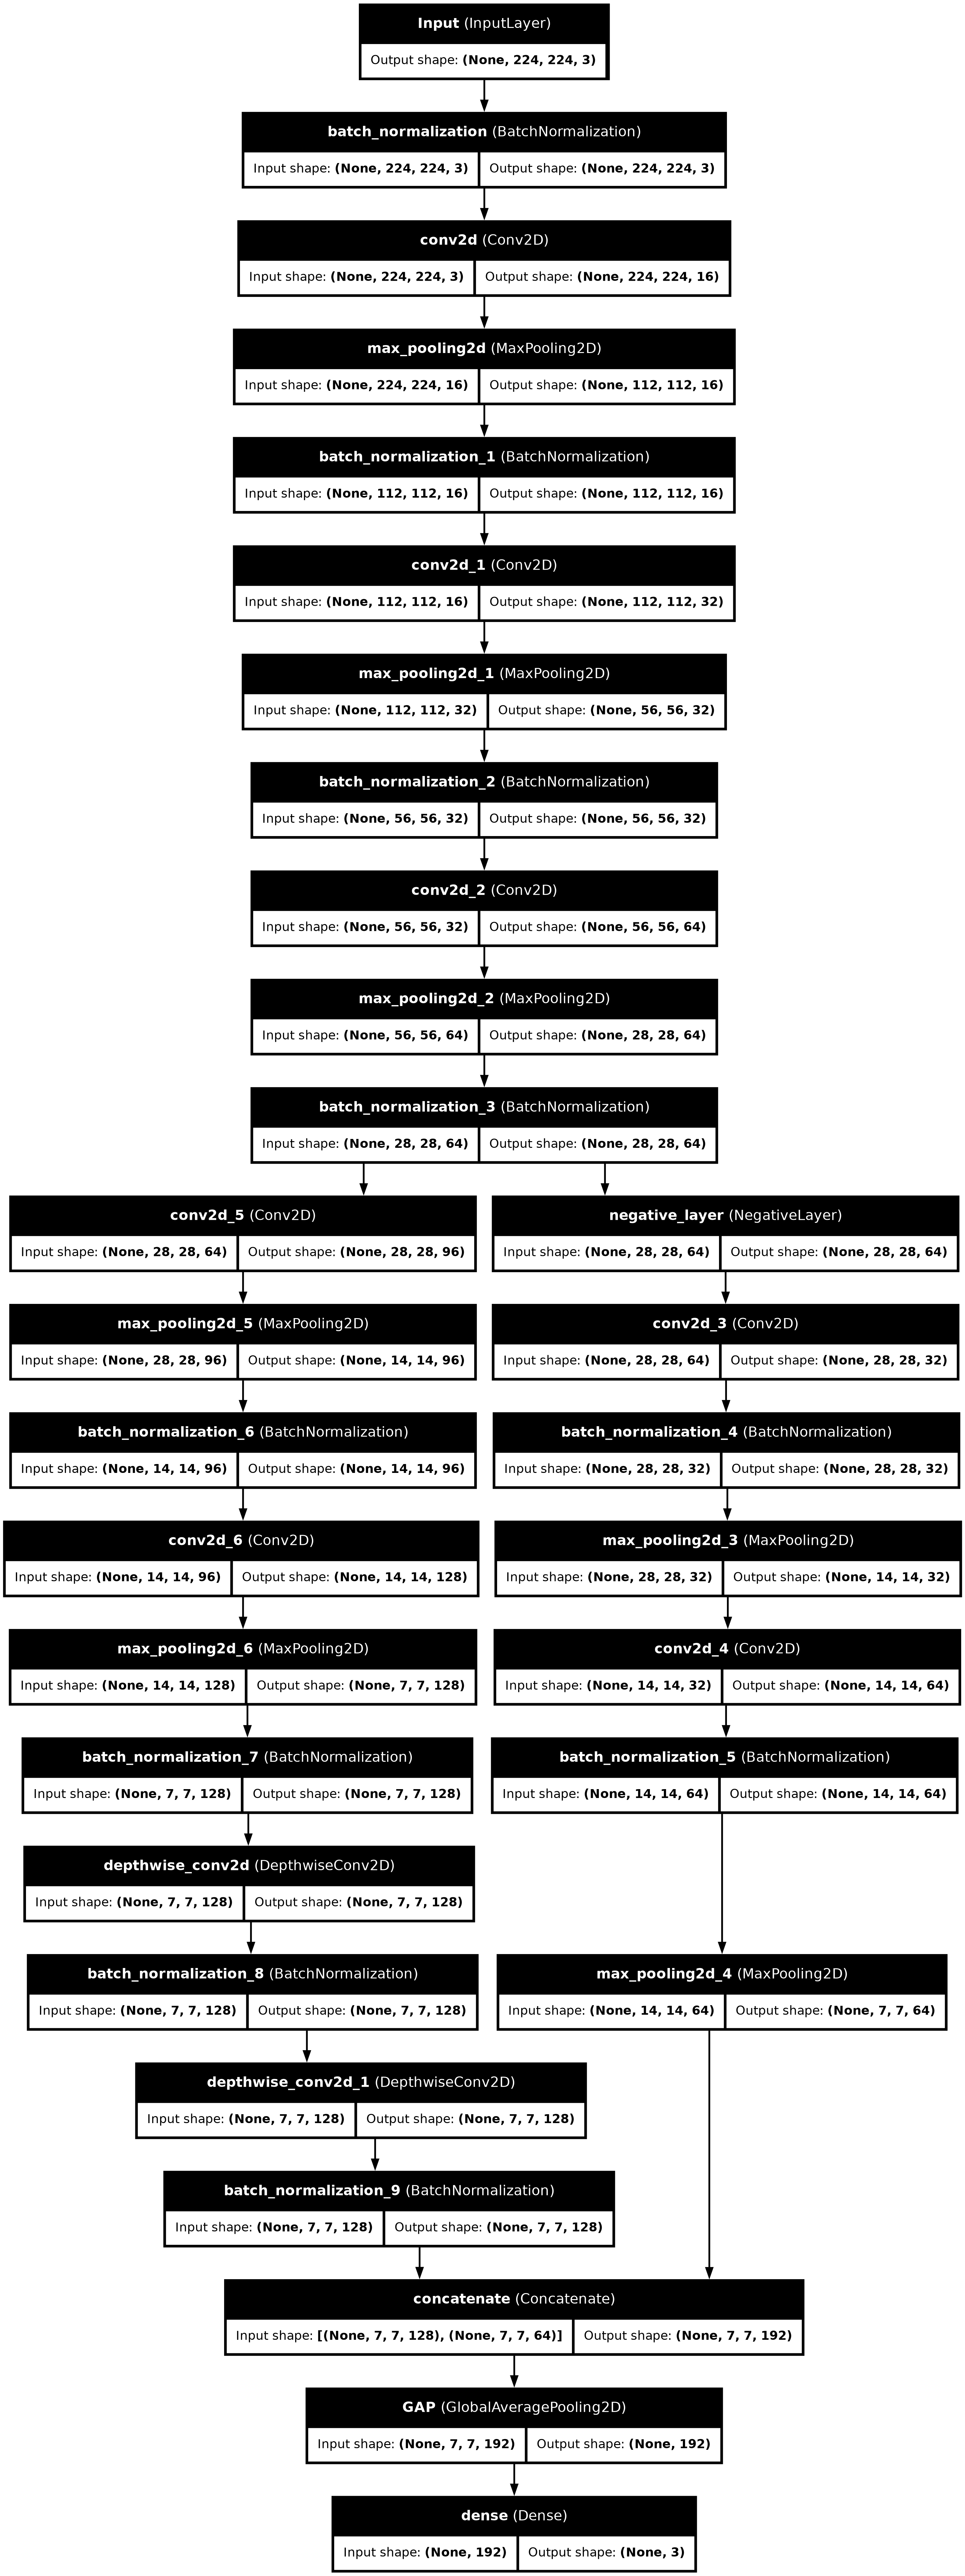

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         12 │ Input[0][0]       │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,216 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     55,392 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        384 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_layer      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (NegativeLayer)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 7, 7, 128) │          0 │ conv2d_6[0][0]  

 Total params: 233,327 (911.43 KB)

 Trainable params: 231,945 (906.04 KB)

 Non-trainable params: 1,382 (5.40 KB)

In [18]:
import tensorflow.keras.backend as K

def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return [
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    ]

In [19]:
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',create_metrics()])
metrics = ['accuracy'] + create_metrics()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)


In [20]:
from keras.callbacks import ReduceLROnPlateau, LambdaCallback
lr_history = []

def record_lr(epoch, logs):
    lr_history.append(model.optimizer.lr.numpy())

lr_recorder = LambdaCallback(on_epoch_end=record_lr)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[lr_scheduler]
)

Epoch 1/15
  3/130 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3542 - auc: 0.4437 - f1_score: 0.2795 - loss: 1.5030 - mcc: 0.0437 - precision: 0.3756 - recall: 0.2266 - sensitivity: 0.2266 - specificity: 0.8116 

I0000 00:00:1719468308.102496     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.5735 - auc: 0.7624 - f1_score: 0.5222 - loss: 0.8878 - mcc: 0.3542 - precision: 0.6250 - recall: 0.4593 - sensitivity: 0.4593 - specificity: 0.8653 - val_accuracy: 0.5048 - val_auc: 0.7255 - val_f1_score: 0.4871 - val_loss: 0.9663 - val_mcc: 0.2487 - val_precision: 0.5083 - val_recall: 0.4702 - val_sensitivity: 0.4678 - val_specificity: 0.7746 - learning_rate: 9.5000e-04
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.7366 - auc: 0.8988 - f1_score: 0.7177 - loss: 0.6151 - mcc: 0.5941 - precision: 0.7698 - recall: 0.6737 - sensitivity: 0.6737 - specificity: 0.8994 - val_accuracy: 0.5303 - val_auc: 0.7860 - val_f1_score: 0.5166 - val_loss: 0.8962 - val_mcc: 0.2835 - val_precision: 0.5297 - val_recall: 0.5063 - val_sensitivity: 0.5052 - val_specificity: 0.7751 - learning_rate: 9.5000e-04
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.8654 - auc: 0.9684 - f1_score: 0.8626 - loss: 0.3754 - mcc: 

In [21]:
result = model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9967 - auc: 0.9998 - f1_score: 0.9967 - loss: 0.0168 - mcc: 0.9951 - precision: 0.9967 - recall: 0.9967 - sensitivity: 0.9967 - specificity: 0.9984


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
              precision    recall  f1-score   support

          CI       1.00      0.99      0.99       572
          AD       1.00      1.00      1.00       119
          CN       0.99      1.00      0.99       464

    accuracy                           0.99      1155
   macro avg       1.00      1.00      1.00      1155
weighted avg       0.99      0.99      0.99      1155



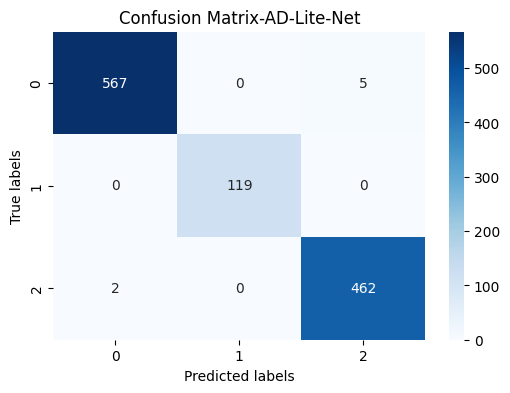

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_val_classes, y_pred_classes, target_names=mapped_dict_2.keys())

print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)

# Calculate true positives for each class
true_positives = np.diag(conf_matrix)

# Plot heatmap with true positives
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix-AD-Lite-Net')
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


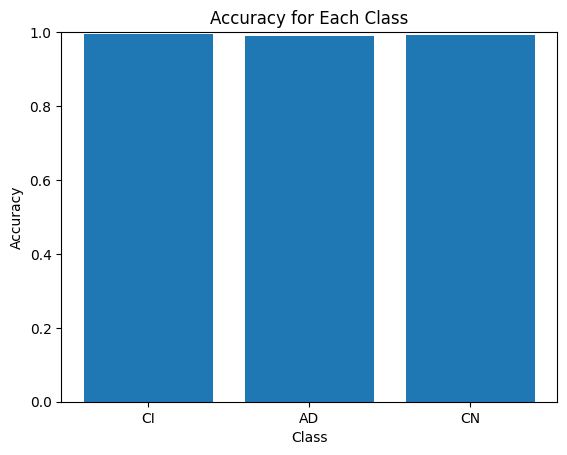

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Calculate the accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Plotting
plt.bar(mapped_dict_2.keys(), class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim([0, 1])  # Set the limit of y-axis to [0,1] for percentage
plt.show()


In [24]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

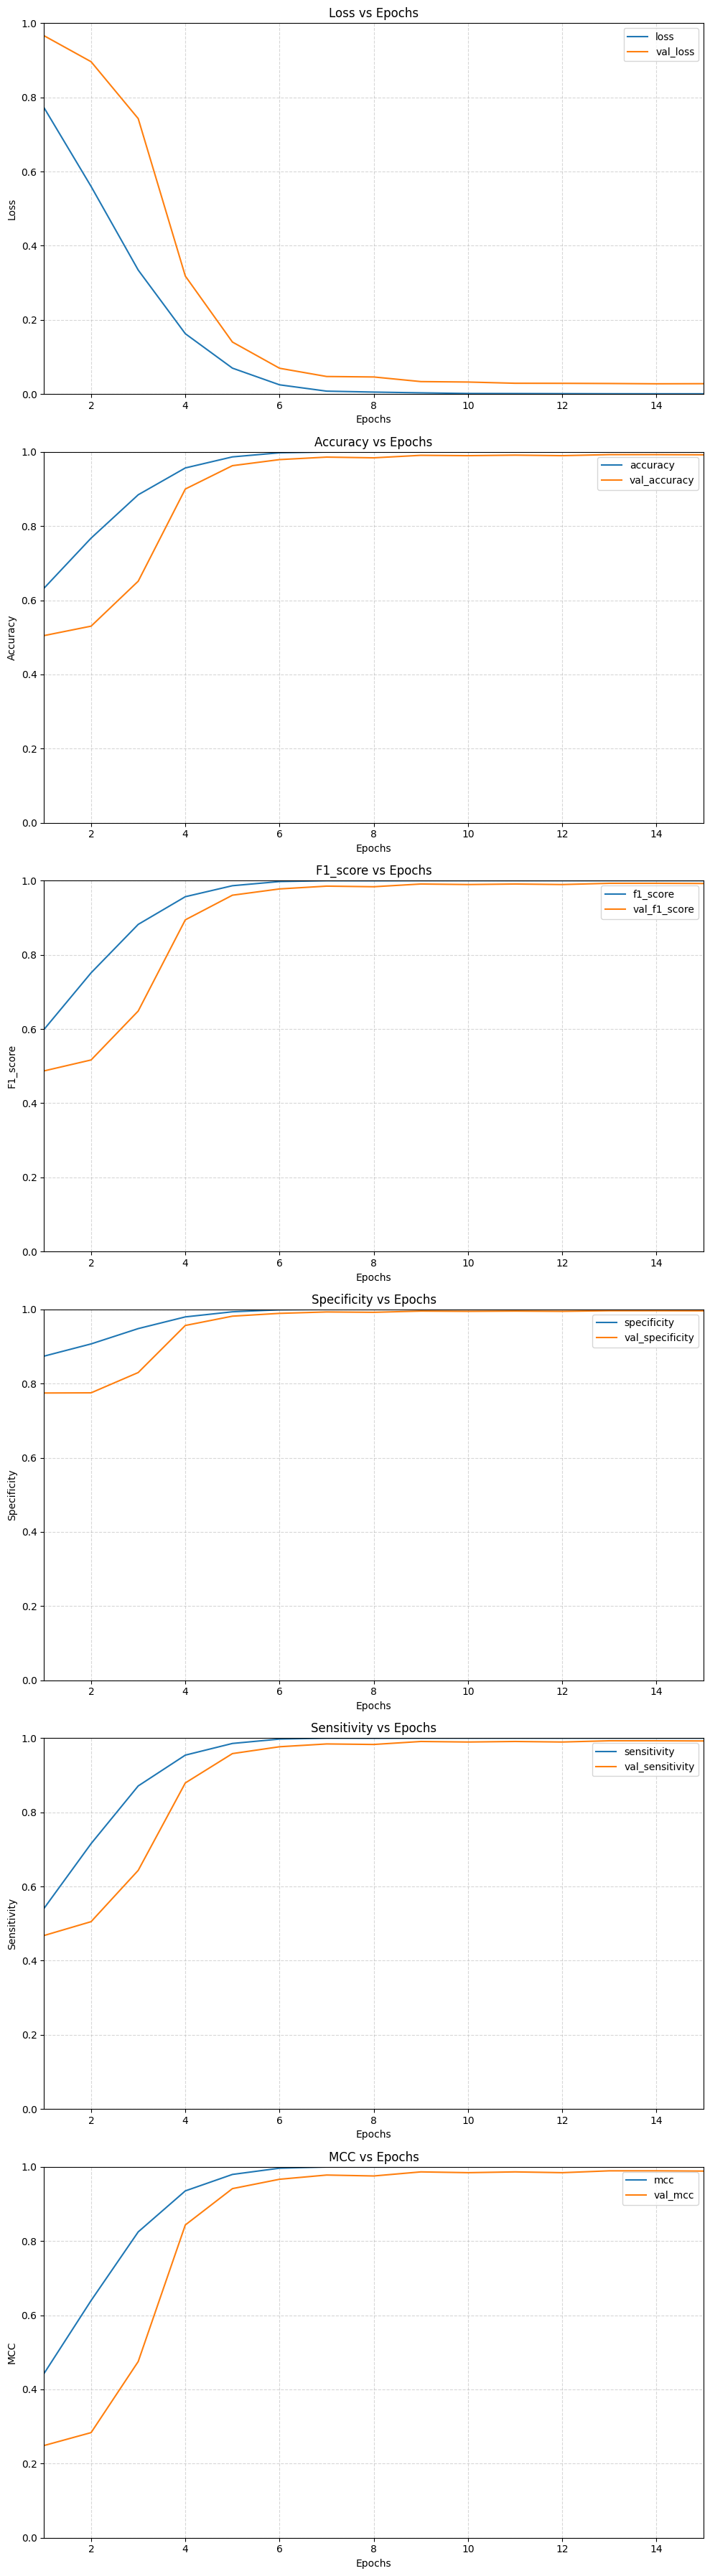

In [25]:
import math
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)